In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1-uuRcH-a-thRr6YQELzthhVo6FuKKVGI'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('stokes_triangle_1000.npz') 


file_id = '1y89bVug8-LRsl7hog8sJseyqq5HNn7a6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ResNet_18.py')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'CLASSES/SP20/ece228/Project/Code/Networks/ResNet/Final_Run2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.getcwd()
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from ResNet_18 import ResNet,BasicBlock

In [0]:
data = np.load('stokes_triangle_1000.npz')

In [0]:
# swap the axes
sdfs = data['sdf']
sdfs = np.swapaxes(sdfs,0,2)
vx   = data['vx']
vx = np.swapaxes(vx,0,2)
vy   = data['vy']
vy = np.swapaxes(vy,0,2)
rho  = data['rho']
rho = np.swapaxes(rho,0,2)

# scale the data
sdf_scaler = StandardScaler()
vx_scaler  = StandardScaler()
vy_scaler  = StandardScaler()
rho_scaler = StandardScaler()

sdf_scaler.fit(sdfs.reshape((-1,1)))
vx_scaler.fit(vx.reshape((-1,1)))
vy_scaler.fit(vy.reshape((-1,1)))
rho_scaler.fit(rho.reshape((-1,1)))

sdfs_scaled = np.reshape((sdf_scaler.transform(sdfs.reshape((-1,1)))),sdfs.shape)
vx_scaled = np.reshape((vx_scaler.transform(vx.reshape((-1,1)))),vx.shape)
vy_scaled = np.reshape((vy_scaler.transform(vy.reshape((-1,1)))),vy.shape)
rho_scaled = np.reshape((rho_scaler.transform(rho.reshape((-1,1)))),rho.shape)


In [0]:
torch_sdf = torch.from_numpy(sdfs_scaled).float()
torch_sdf = torch_sdf.unsqueeze(1)
torch_vx  = torch.from_numpy(vx_scaled).float()
torch_vy  = torch.from_numpy(vy_scaled).float()
torch_rho = torch.from_numpy(rho_scaled).float()

Y = torch.stack((torch_vx,torch_vy),dim=1)


In [0]:
torch.set_grad_enabled(False)
block = BasicBlock
model = ResNet(block = block,layers = [2,2,2,2],num_channels=128)

run_data = torch.load(base_dir + 'run_1.pt',map_location = torch.device('cpu'))

In [14]:
run_data.keys()

dict_keys(['tr_loss', 'val_loss', 'n_epochs', 'lr', 'batch_size', 'num_channels', 'model'])

In [15]:
model.load_state_dict(run_data['model'])

<All keys matched successfully>

In [0]:
def disp_plots(true, out, title = ""):
    ''' Function to plot and save the true and generated velocity fields'''
    true_np = true.cpu().detach().numpy()
    out_np = out.cpu().detach().numpy()
    
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.suptitle(title)
    axs[0,0].imshow(true_np[0,0,:,:])
    axs[0,0].set_title("X velocities ground truth")
    
    axs[0,1].imshow(out_np[0,0,:,:])
    axs[0,1].set_title("X velocities model output")
    
    axs[1,0].imshow(true_np[0,1,:,:])
    axs[1,0].set_title("Y velocities ground truth")
    
    axs[1,1].imshow(out_np[0,1,:,:])
    axs[1,1].set_title("Y velocities model output")
    plt.show()
    
    # filename = title.replace(' ', '_').lower() + '.png'
    # fig.savefig(filename)

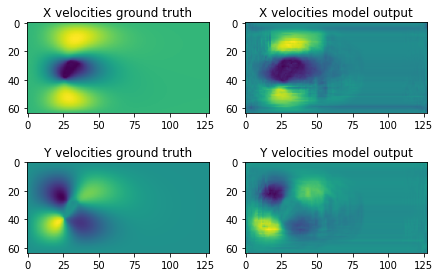

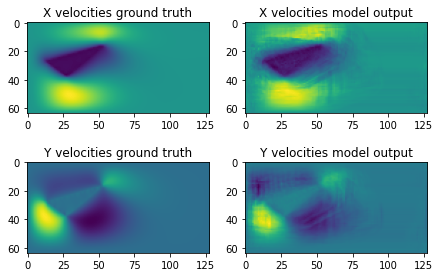

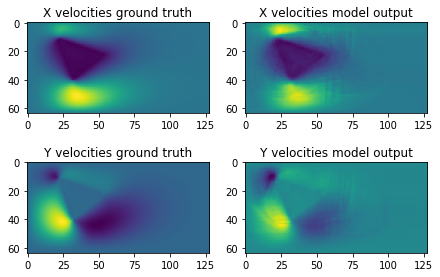

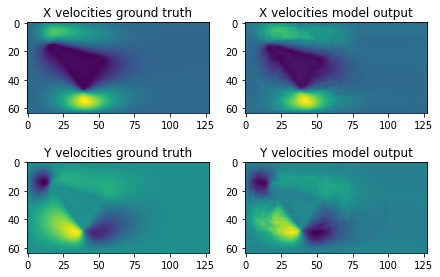

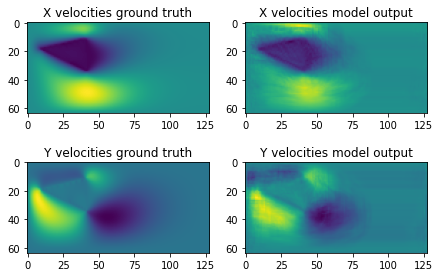

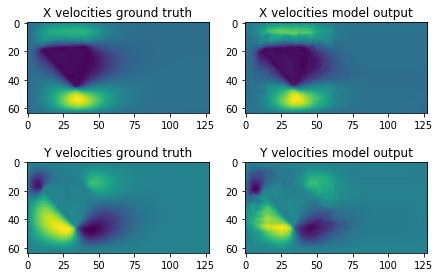

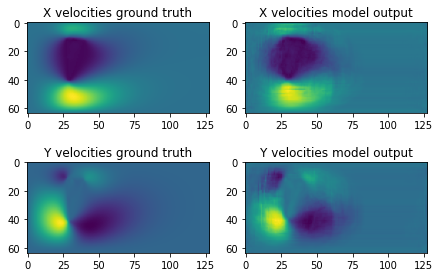

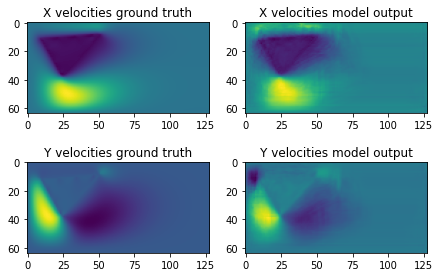

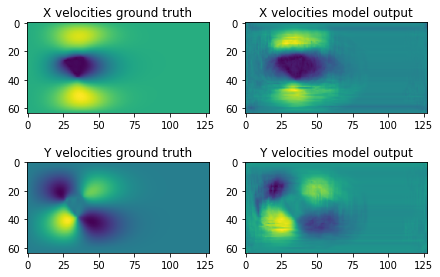

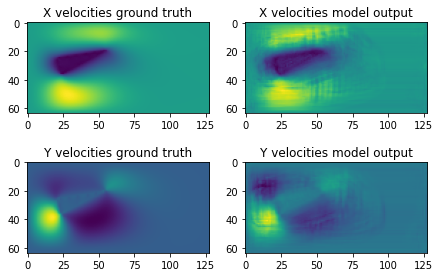

In [17]:
for i in range(10):

  out = model.forward(torch_sdf[i].view(1,1,torch_sdf[i].shape[1],torch_sdf[i].shape[2]))
  disp_plots(Y[i].view(1,2,64,128),out)

In [0]:
Y[1].shape

torch.Size([2, 64, 128])

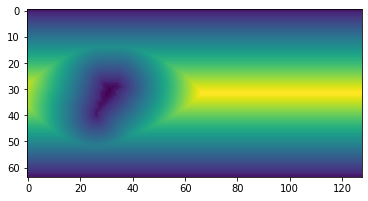

In [0]:
plt.imshow(sdfs_scaled[0])

In [0]:
tr_loss = run_data['tr_loss']
val_loss = run_data['val_loss']

[]

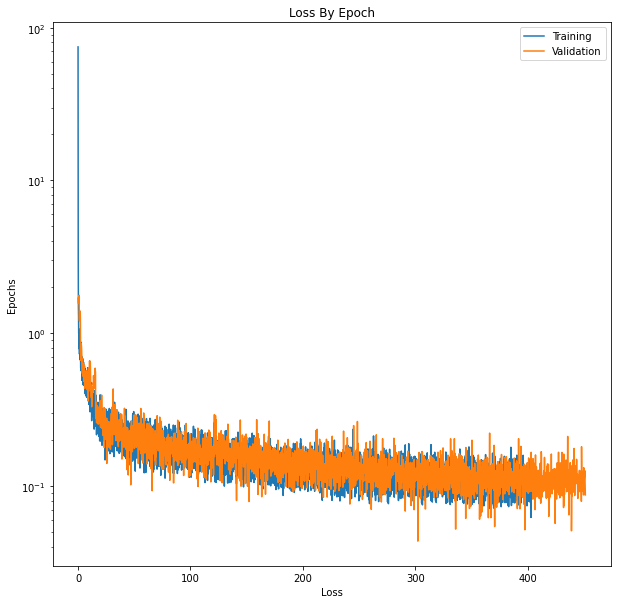

In [21]:
plt.figure(figsize=(10,10))
plt.plot([i*32/800 for i in range(len(tr_loss))],tr_loss)
plt.plot([i*32/200 for i in range(len(val_loss))],val_loss)
plt.title('Loss By Epoch')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.yscale('log')
plt.legend(['Training','Validation'])
plt.plot()

In [0]:
len(val_loss)

728

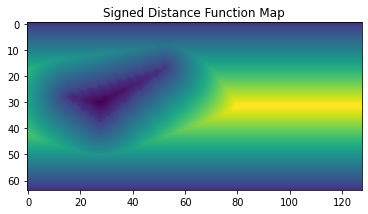

In [0]:
plt.imshow(sdfs[1])
plt.title('Signed Distance Function Map')
plt.show()

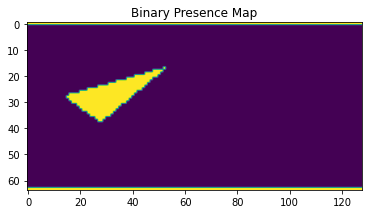

In [0]:
plt.imshow([sdfs[1]<=0][0])
plt.title('Binary Presence Map')
plt.show()

In [0]:
sdfs[0]<=0

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

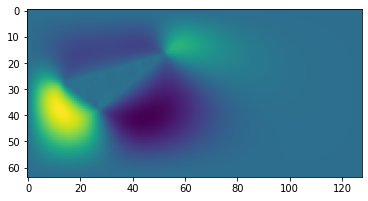

In [0]:
plt.imshow(vy[1])